In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [2]:
btc = pd.read_csv('./Data/BTC-USD.csv')

In [3]:
# Ajout d'un nom pour la col 'Date' et Convertion en datetime et index

btc.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
btc['Date'] = pd.to_datetime(btc.Date)

In [4]:
#Set Date as Index
btc.set_index('Date', inplace=True)

In [5]:
# Selecting only the dates from 2017-01-01 onwards when Bitcoin popularity increased.
#btc = btc[['close']].loc['2017-01-01':]

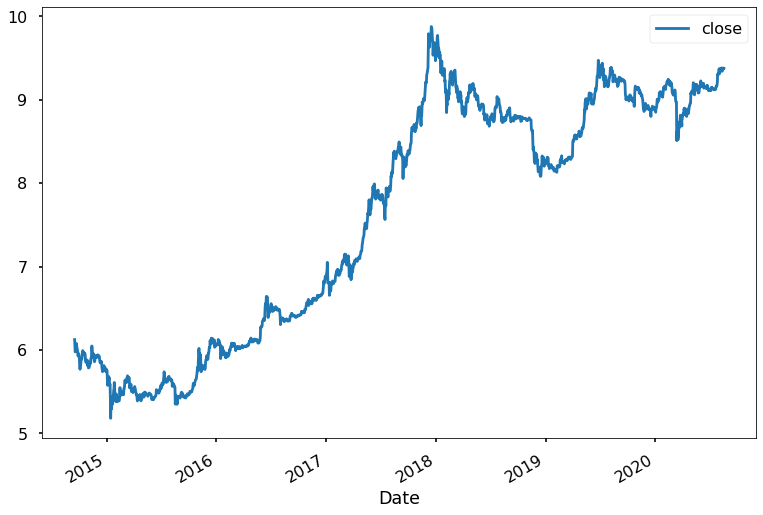

In [6]:
# Converting the data to a logarithmic scale
btc_log = pd.DataFrame(np.log(btc.close))

btc_log.plot()

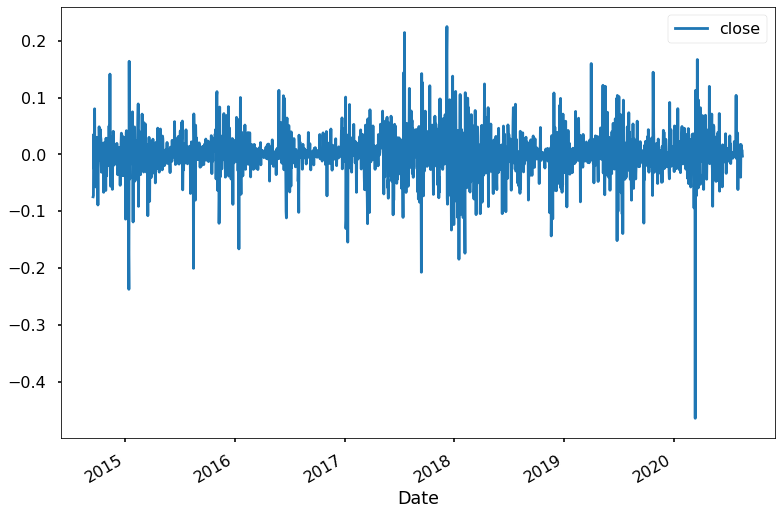

In [7]:
# Differencing the log values
log_diff = btc_log.diff().dropna()
log_diff.plot()

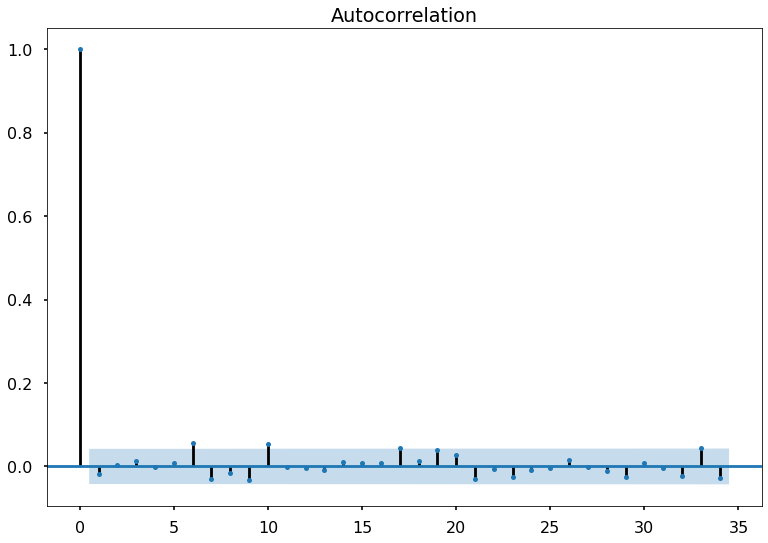

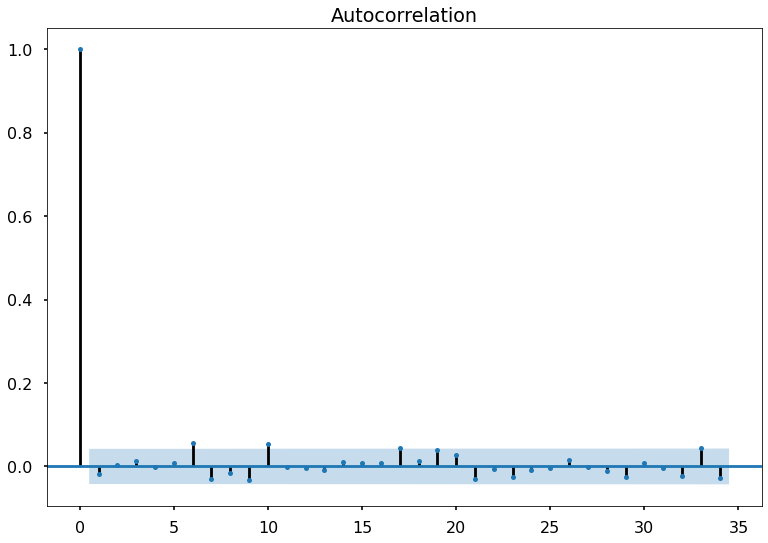

In [8]:
#ACF (Auto Correlation Function)
plot_acf(log_diff)

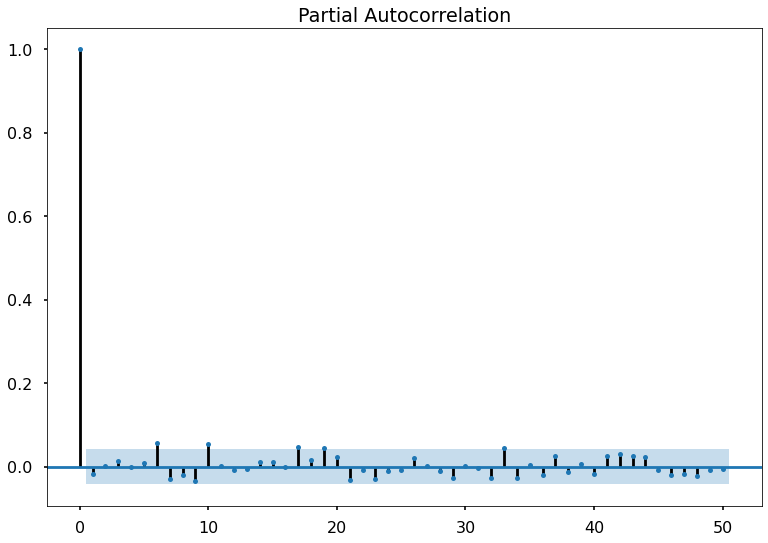

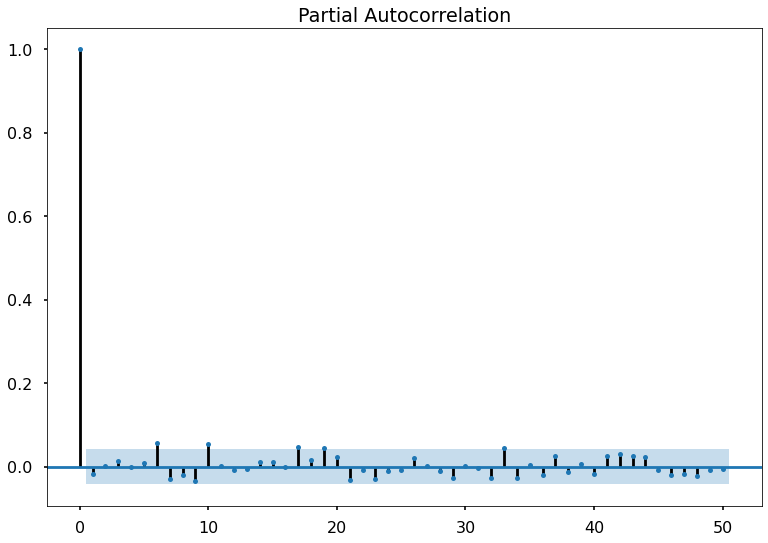

In [9]:
#PACF (Partial Autocorrelation Function)
plot_pacf(log_diff, lags=50)


In [10]:
# Resampling to daily frequency
btc = btc.resample('D').mean()

In [11]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

In [12]:
# Resampling to annual frequency
btc_year = btc.resample('A-DEC').mean()

In [13]:
# Resampling to quarterly frequency
btc_Q = btc.resample('Q-DEC').mean()

In [14]:
print(btc_Q)

open          high           low         close  \
Date                                                                 
2014-09-30    410.972203    419.122727    397.014998    405.611265   
2014-12-31    357.489977    365.706496    349.127143    356.783495   
2015-03-31    251.876150    259.397673    244.346667    251.233595   
2015-06-30    236.820231    239.742999    234.072561    236.983022   
2015-09-30    255.048250    259.027164    251.176793    254.630629   
2015-12-31    345.084022    354.740427    337.854726    347.229318   
2016-03-31    410.916022    415.805649    405.104133    410.645934   
2016-06-30    512.671285    522.603746    504.375000    515.331612   
2016-09-30    615.723415    620.969695    609.070715    615.025285   
2016-12-31    730.312307    738.926791    724.267317    734.026814   
2017-03-31   1034.897077   1057.803084   1009.209074   1035.532426   
2017-06-30   1913.249561   1981.458236   1860.693196   1927.431869   
2017-09-30   3482.285649   3604.249989  

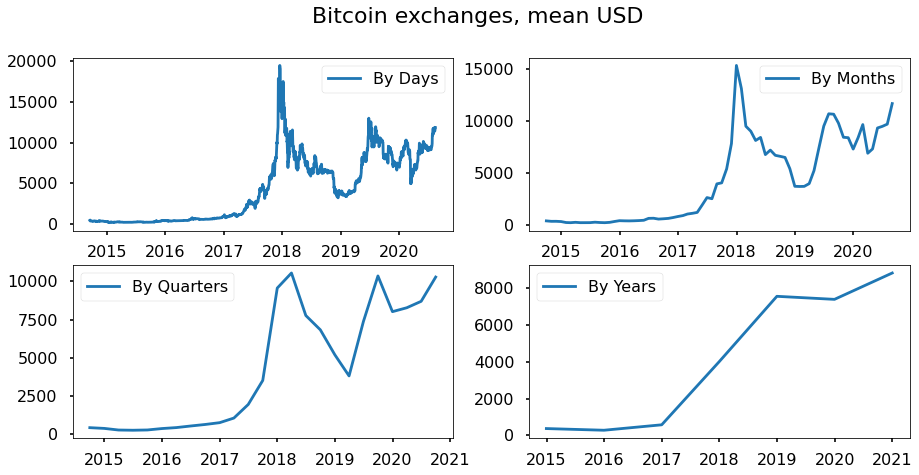

In [15]:
# PLOTS Daily / Months / Quarters / Years
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(btc.adjclose, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(btc_month.adjclose, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(btc_Q.adjclose, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(btc_year.adjclose, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: P-value = 0.624649


<Figure size 1080x504 with 0 Axes>

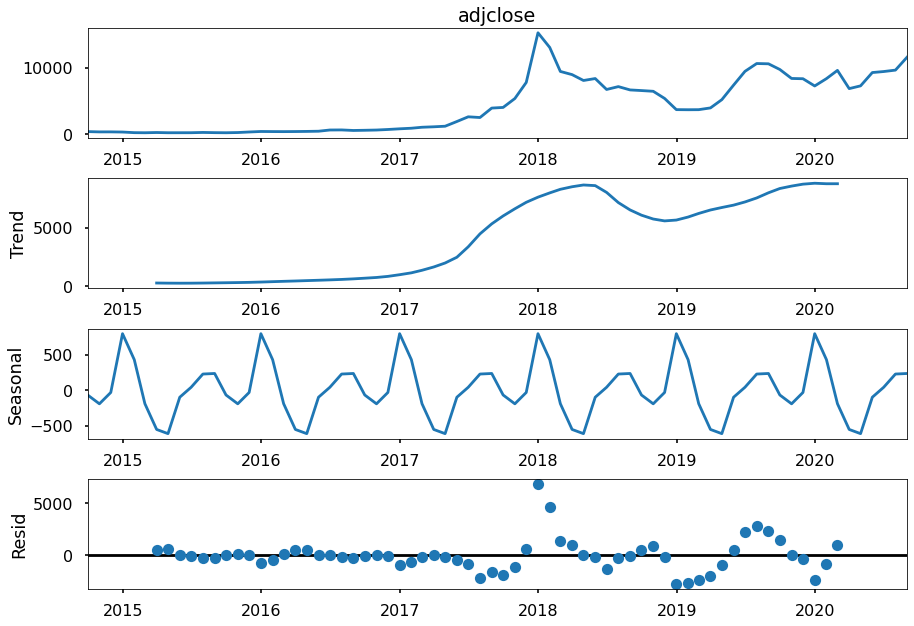

In [16]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc_month.adjclose).plot()
print("Dickey–Fuller test: P-value = %f" % sm.tsa.stattools.adfuller(btc_month.adjclose)[1])
plt.show()

In [17]:
#Observation : la serie n'est pas stationnaire

In [18]:
# Box-Cox Transformations

btc_month['adjclose_box'], lmbda = stats.boxcox(btc_month.adjclose)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_month.adjclose)[1])
plt.show()

Dickey–Fuller test: p=0.624649


In [19]:
# Seasonal differentiation
btc_month['adjclose_box_diff'] = btc_month.adjclose_box - btc_month.adjclose_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_month.adjclose_box_diff[12:])[1])

Dickey–Fuller test: p=0.255635


Dickey–Fuller test: p=0.000011


<Figure size 1080x504 with 0 Axes>

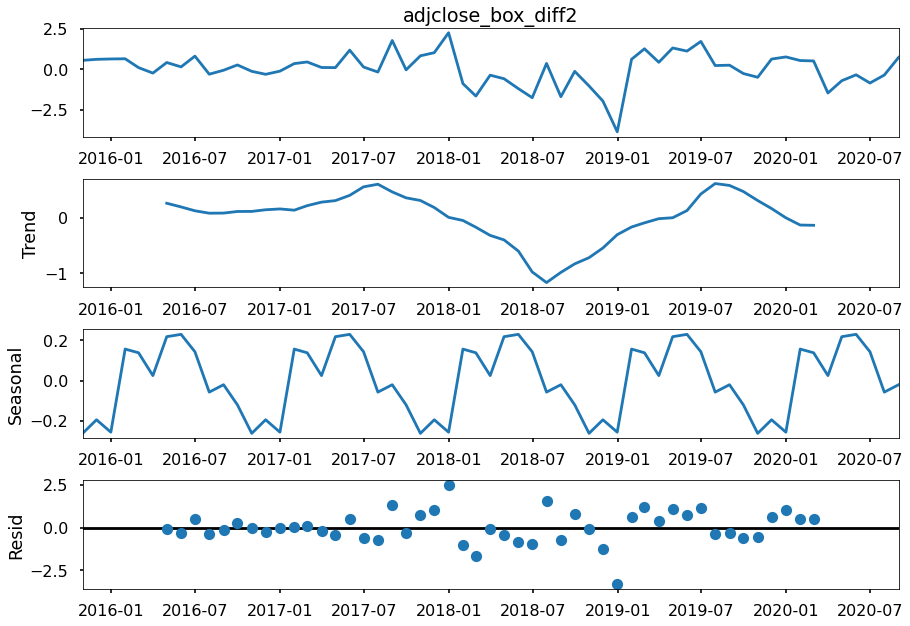

In [20]:
# Regular differentiation
btc_month['adjclose_box_diff2'] = btc_month.adjclose_box_diff - btc_month.adjclose_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(btc_month.adjclose_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_month.adjclose_box_diff2[13:])[1])

plt.show()

In [21]:
#Observation : La série est stationnaire

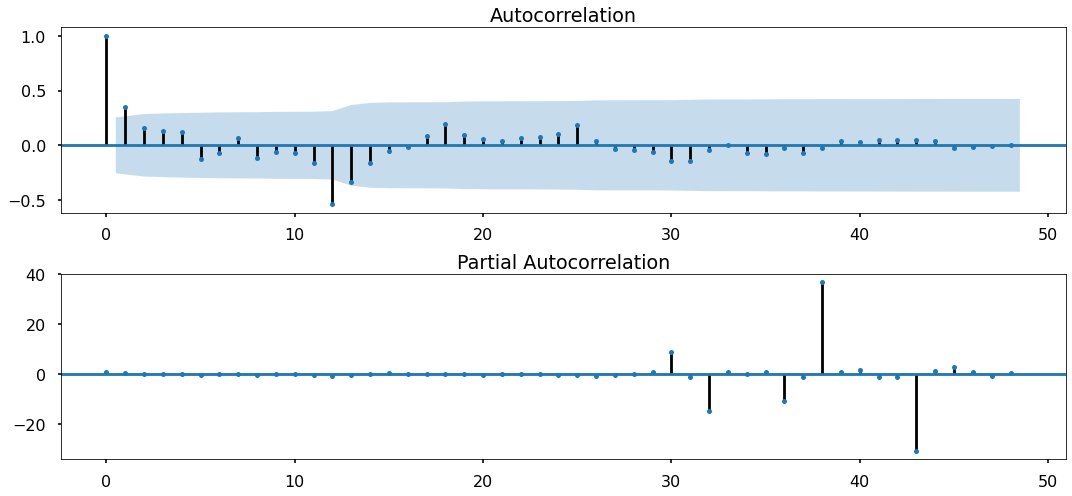

In [22]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(btc_month.adjclose_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(btc_month.adjclose_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [23]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [24]:
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(btc_month.adjclose_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [25]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

parameters         aic
19  (1, 0, 0, 1)  139.911334
11  (0, 1, 2, 1)  139.958089
7   (0, 1, 0, 1)  140.026369
23  (1, 0, 2, 1)  140.301911
21  (1, 0, 1, 1)  141.291456
                                      SARIMAX Results                                       
Dep. Variable:                         adjclose_box   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -66.956
Date:                              Sun, 16 Aug 2020   AIC                            139.911
Time:                                      20:05:34   BIC                            146.144
Sample:                                  09-30-2014   HQIC                           142.344
                                       - 08-31-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

Dickey–Fuller test:: p=0.000000


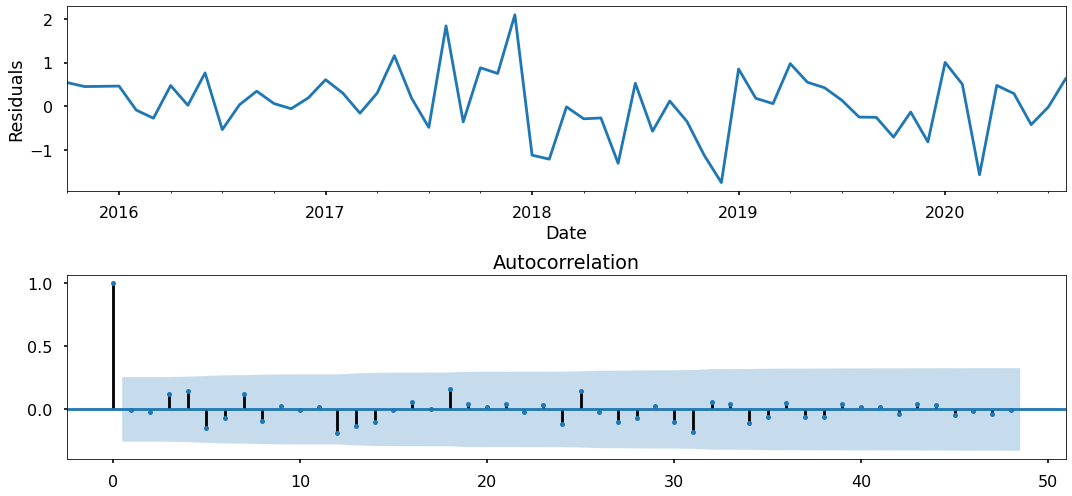

In [26]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [27]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

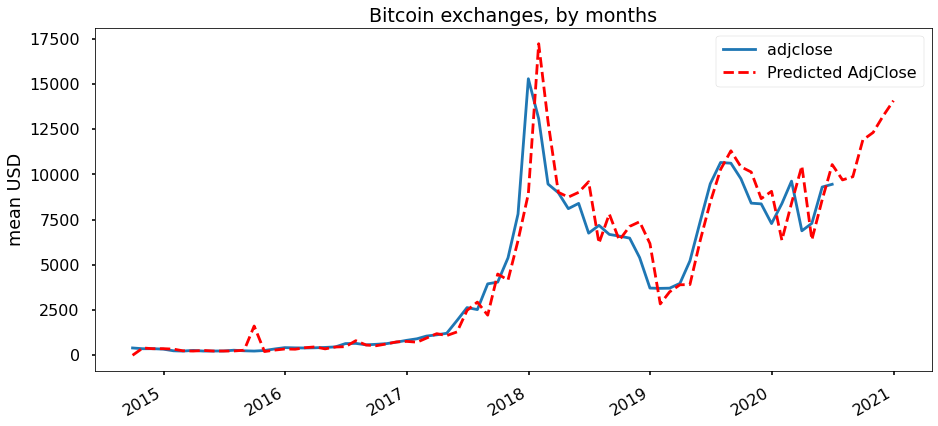

In [28]:
# Prediction
btc_month2 = btc_month[['adjclose']]
date_list = [datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30), 
             datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31),
             datetime(2021, 1, 28)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])
btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
btc_month2.adjclose.plot()
btc_month2.forecast.plot(color='r', ls='--', label='Predicted AdjClose')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [29]:
#Show only most recents values (Forecast after today)
today = str(datetime.today())
btc_month2_recent = btc_month2[['forecast']].loc[today:]
print(btc_month2_recent['forecast'])

2020-08-31     9875.362808
2020-08-31     9875.362808
2020-09-30    11906.252922
2020-10-31    12323.743429
2020-11-30    13237.604530
2020-12-31    14081.898428
2021-01-31             NaN
2021-01-28             NaN
Name: forecast, dtype: float64


In [30]:
#Saving Model ARIMA BTC-USD AR
best_model.save('./models/ARIMA BTC-USD AR')